In [2]:
import os
import torch
import tqdm
import matplotlib.pyplot as plt
import numpy as np 

from dp_gs.dataset.image_dataset import SequenceDataset
from dp_gs.dataset.image_dataset_sim import SequenceDataset as SimSequenceDataset
from dp_gs.util.args import ExperimentConfig
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from dp_gs.dataset.utils import default_vision_transform
from dp_gs.dataset.utils import unscale_action
from transformers import AutoProcessor

/home/mfu/miniconda3/envs/dp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
tokenizer = AutoProcessor.from_pretrained("physical-intelligence/fast", trust_remote_code=True)
# tokenizer = AutoProcessor.from_pretrained("physical-intelligence/fast", trust_remote_code=True).from_pretrained("/home/mfu/research/dp_gs/output/test_large_fast_tokenizer")
# tokenizer = AutoProcessor.from_pretrained("/home/mfu/research/dp_gs/output/fast_tokenizer", trust_remote_code=False)

Some kwargs in processor config are unused and will not have any effect: action_dim, time_horizon, min_token, scale, vocab_size. 


In [7]:
import yaml 
from pathlib import Path

train_yaml_path = "/shared/projects/icrl/dp_outputs/250202_2319/run.yaml"
args : ExperimentConfig = yaml.load(Path(train_yaml_path).read_text(), Loader=yaml.Loader)
number_of_samples = 100
out_dir = "test_outputs/test_dataset_output"
args.logging_cfg.output_dir = out_dir
os.makedirs(out_dir, exist_ok=True)
# sim = True
# args.dataset_cfg.dataset_root = "/home/mfu/dataset/dp_gs/sim_bimanual_tiger_250124_1935"
sim = False
args.dataset_cfg.dataset_root = "/home/yujustin/dataset/dp_gs/sim_pick_tiger_bimanual_jaxmp/successes_020625"

# # hack : change the context window to 50 
# args.shared_cfg.num_pred_steps = 50

vision_transform = default_vision_transform()
print("vision transform: ", vision_transform)
mean, std = IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

# making train val split
if sim: 
    dataset_cls = SimSequenceDataset
else:
    dataset_cls = SequenceDataset
dataset_train = dataset_cls(
    dataset_config=args.dataset_cfg,
    shared_config=args.shared_cfg,
    logging_config=args.logging_cfg,
    vision_transform=vision_transform,
    split="train",
    debug=False,
)

vision transform:  Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    MaybeToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)


100%|██████████| 1570/1570 [00:09<00:00, 162.67it/s]


Action statistics saved to  test_outputs/test_dataset_output/action_statistics.json
using numeric brightness and contrast augmentation
contrast range:  [0.8, 1.2]
brightness range:  [-0.1, 0.1]


In [106]:
# generate some data to get statistics

actions = []
# action dimension torch.Size([16, 20])
number_of_samples = 32
indices = np.random.randint(0, len(dataset_train), size=number_of_samples)
for i in indices:
    actions.append(dataset_train[i]["action"])
all_actions = np.stack(actions)
og_actions = unscale_action(torch.tensor(all_actions), stat=dataset_train.stats, type='diffusion').numpy()

In [131]:
# tokenize and decode
tokens = tokenizer(all_actions)

all_lengths = [len(i) for i in tokens]
print("max min all lengths of tokens", max(all_lengths), min(all_lengths))

decoded_actions = tokenizer.decode(tokens, time_horizon=args.shared_cfg.num_pred_steps, action_dim=20)
decoded_actions = unscale_action(torch.tensor(decoded_actions), stat=dataset_train.stats, type='diffusion').numpy()
diff = decoded_actions - og_actions

max min all lengths of tokens 57 28


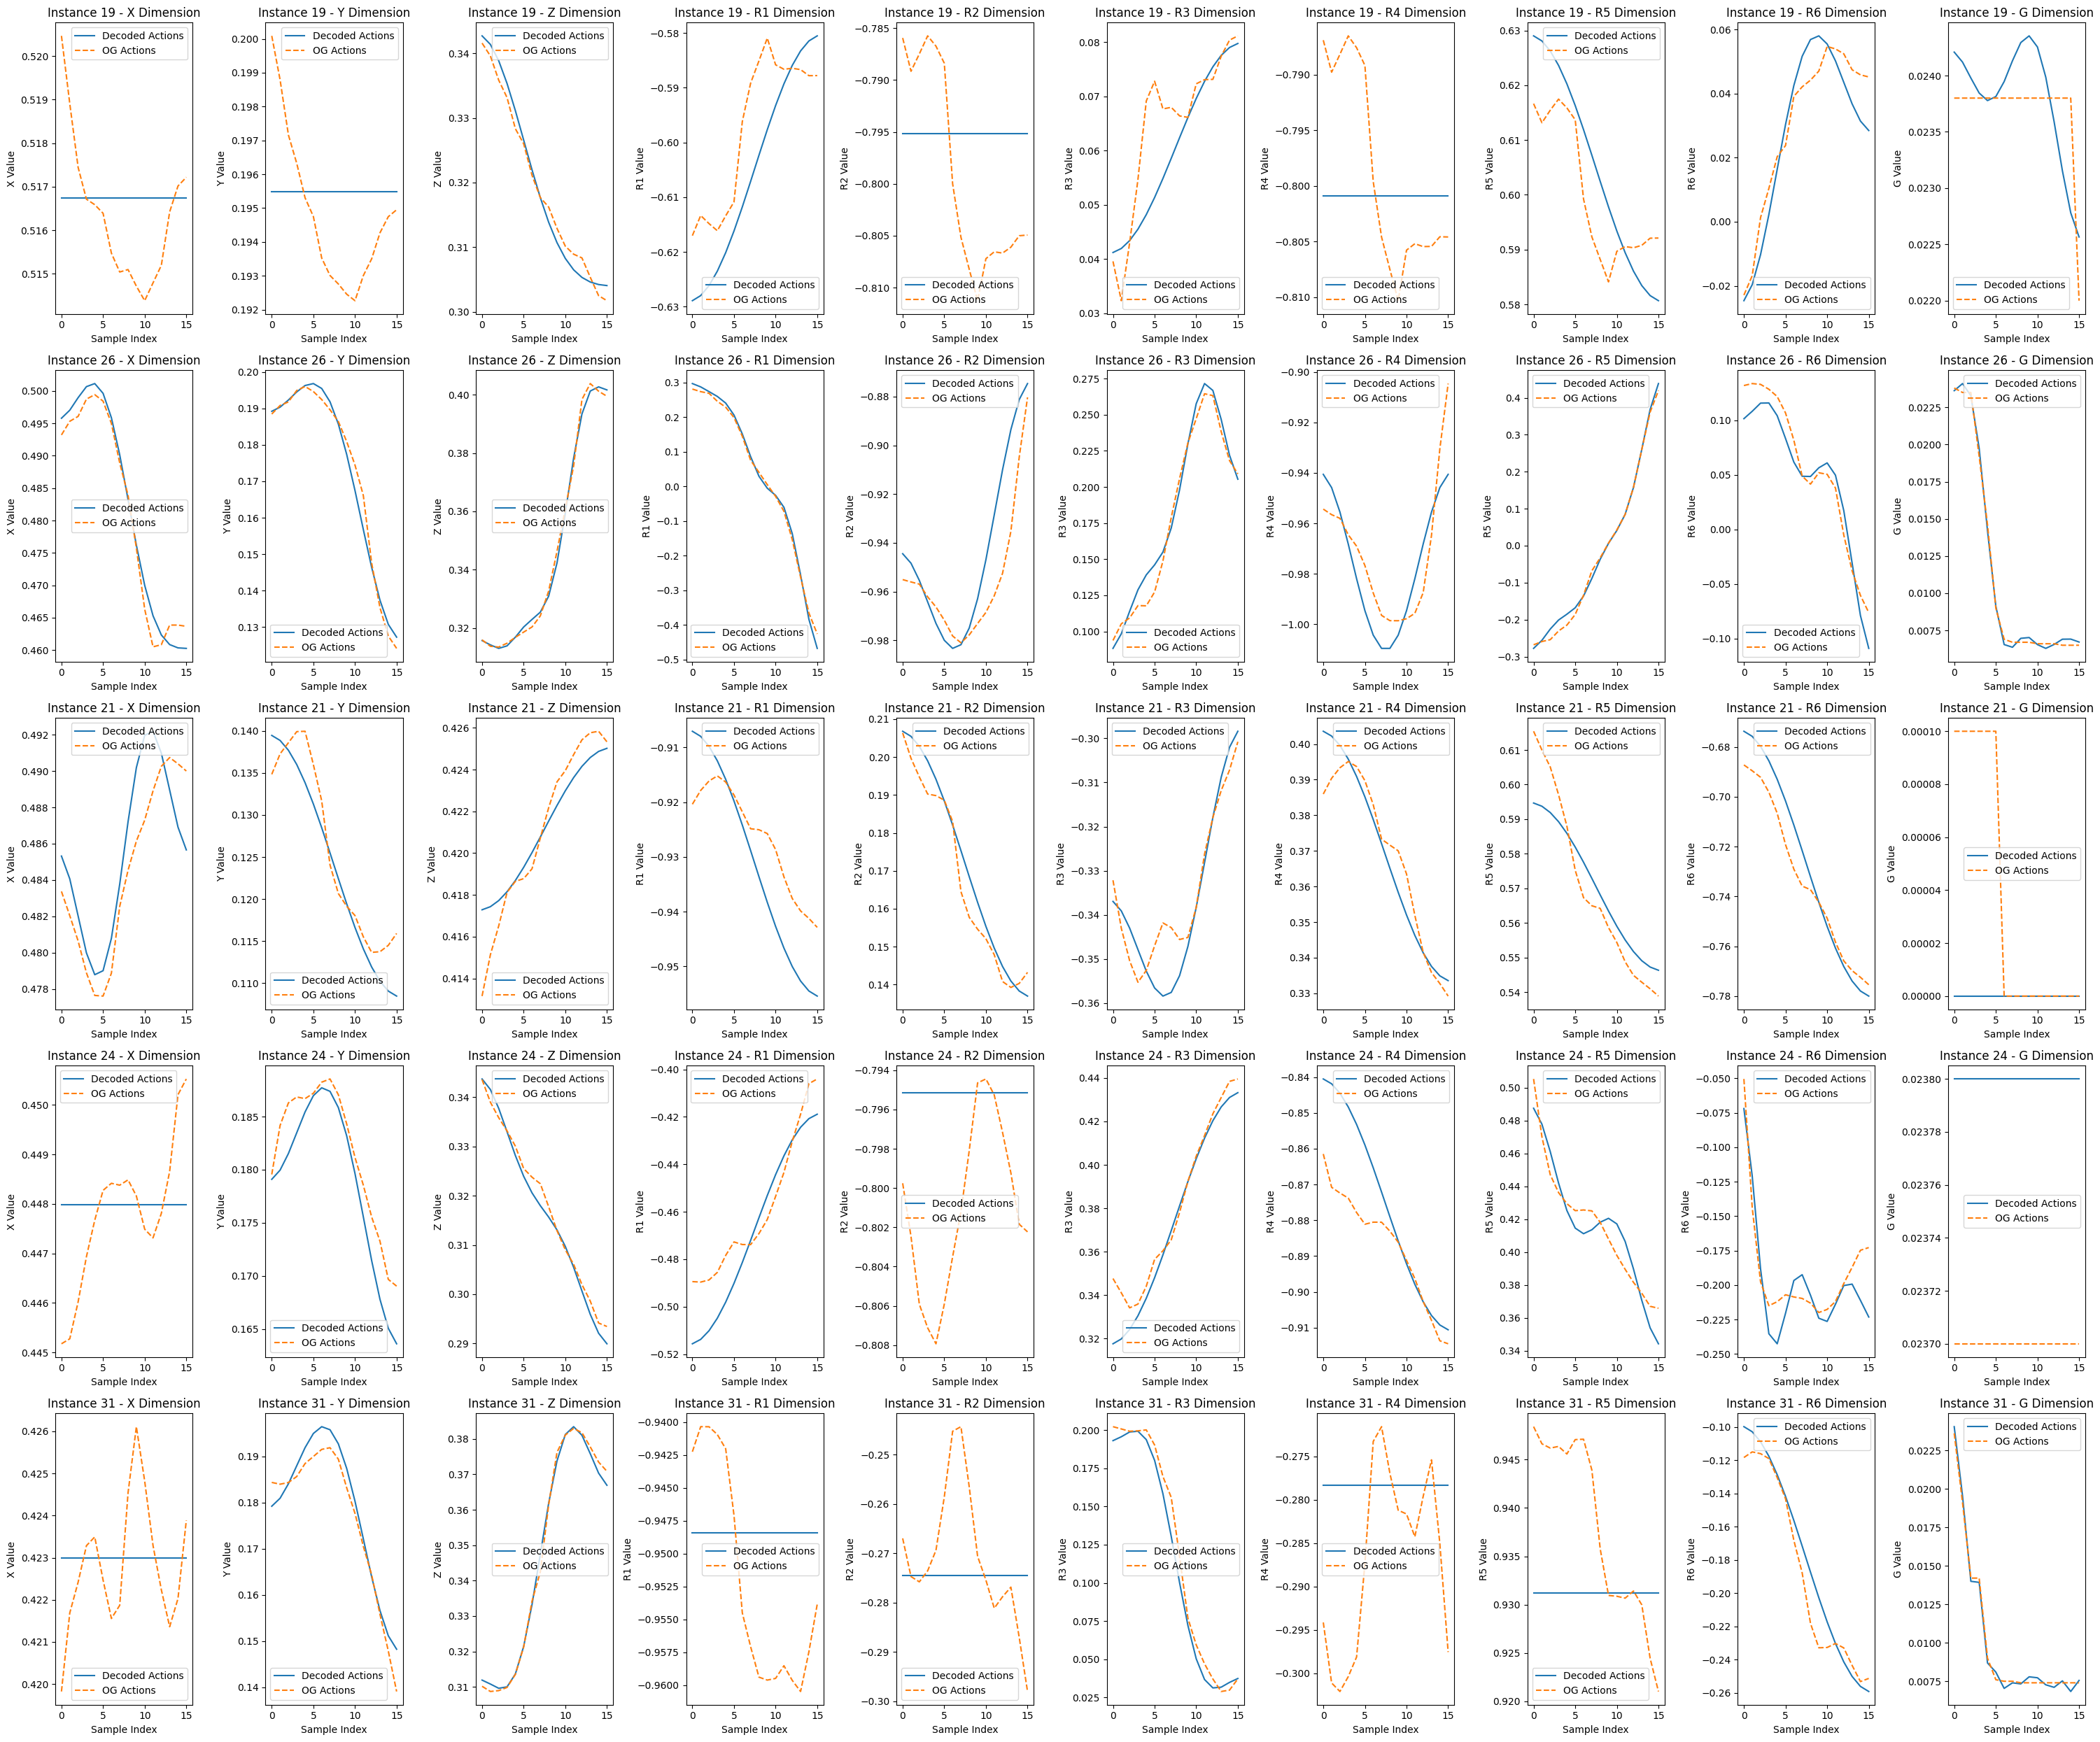

In [132]:
# Select 5 random indices
random_indices = np.random.choice(len(decoded_actions), 5, replace=False)

fig, axes = plt.subplots(5, 10, figsize=(30, 25))

dimensions = ['X', 'Y', 'Z', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', "G"]

for row, instance_index in enumerate(random_indices):
    for col in range(10):
        axes[row, col].plot(decoded_actions[instance_index, :, col], label='Decoded Actions')
        axes[row, col].plot(og_actions[instance_index, :, col], label='OG Actions', linestyle='--')
        axes[row, col].set_title(f'Instance {instance_index} - {dimensions[col]} Dimension')
        axes[row, col].set_xlabel('Sample Index')
        axes[row, col].set_ylabel(f'{dimensions[col]} Value')
        axes[row, col].legend()

plt.tight_layout()
plt.show()

In [133]:
# norm
print(diff.max(), diff.min())
cartesian_diff = np.linalg.norm(diff[:, :, :3], axis=-1)
cartesian_diff_first = cartesian_diff[:, 0]
cartesian_diff_last = cartesian_diff[:, -1]

print("Tokenization error on first action cartesian norm")
print(cartesian_diff_first.max(), cartesian_diff_first.min())
print("Tokenization error on last (16) action cartesian norm")
print(cartesian_diff_last.max(), cartesian_diff_last.min())

0.05873767809451402 -0.0562866566132294
Tokenization error on first action cartesian norm
0.010482919549054384 0.0010488371156495559
Tokenization error on last (16) action cartesian norm
0.015174451364670839 0.0003867570785371929


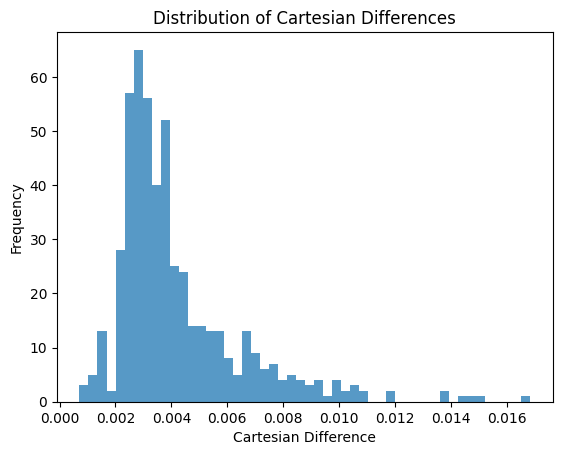

Number of cartesian differences larger than 0.01: 17 out of 512


In [97]:
plt.hist(cartesian_diff.flatten(), bins=50, alpha=0.75)
plt.title('Distribution of Cartesian Differences')
plt.xlabel('Cartesian Difference')
plt.ylabel('Frequency')
plt.show()
count_large_diff = np.sum(cartesian_diff > 0.01)
print("Number of cartesian differences larger than 0.01:", count_large_diff, "out of", cartesian_diff.size)


In [ ]:
# 1. scipy fft dct idct - check error 
# 2. try longer context window (i.e. 50)
# 3. try different scale factors

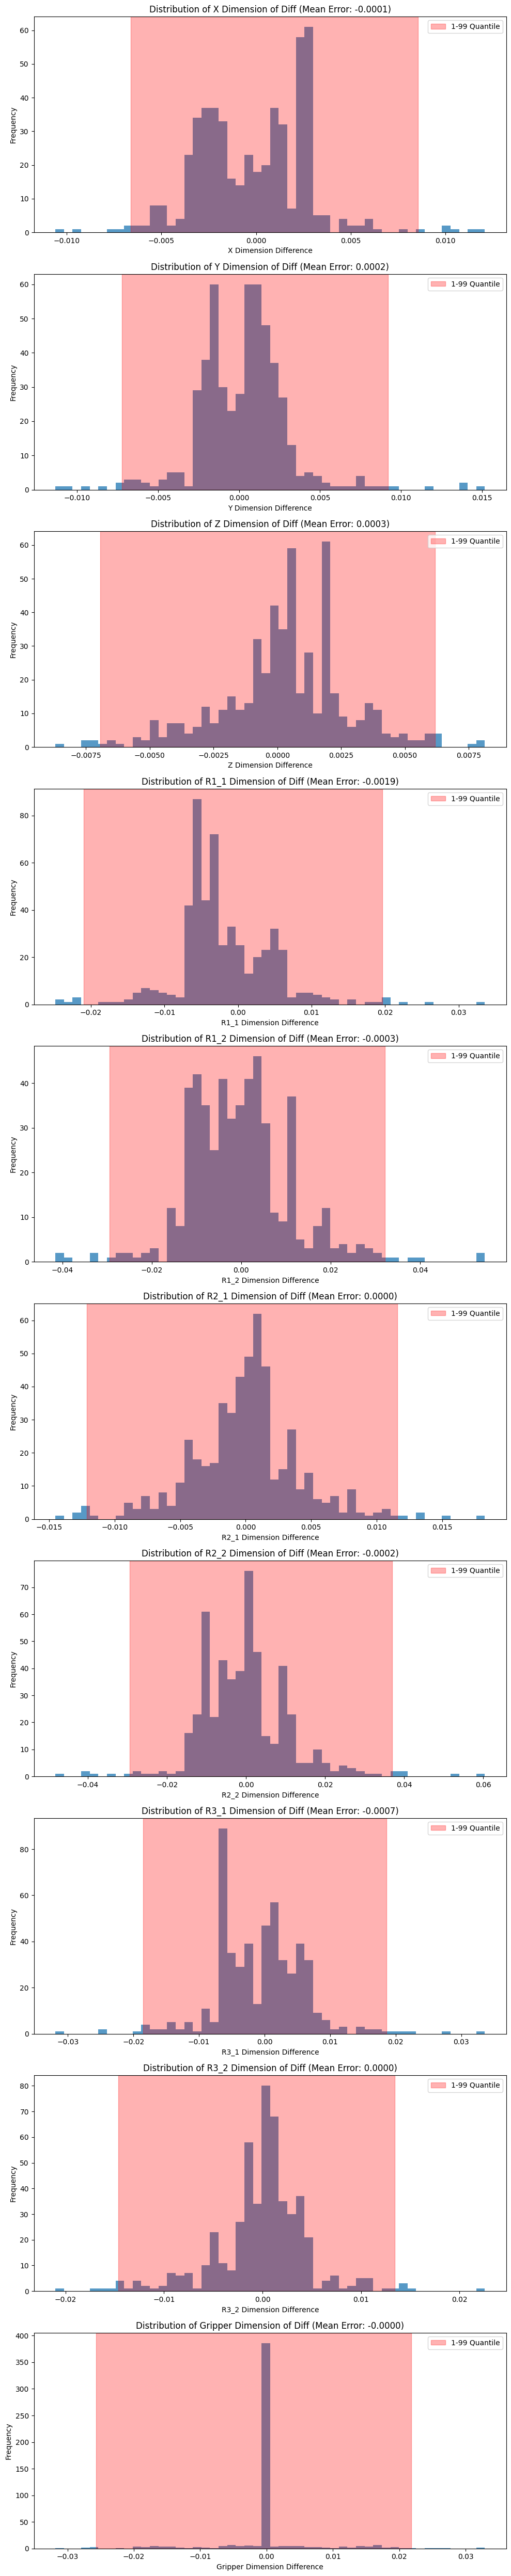

In [98]:
fig, axes = plt.subplots(10, 1, figsize=(10, 50))

dimensions = ['X', 'Y', 'Z', 'R1_1', 'R1_2', 'R2_1', 'R2_2', 'R3_1', 'R3_2', 'Gripper']
for i in range(10):
    axes[i].hist(diff[:, :, i].flatten(), bins=50, alpha=0.75)
    mean_error = diff[:, :, i].mean()
    axes[i].set_title(f'Distribution of {dimensions[i]} Dimension of Diff (Mean Error: {mean_error:.4f})')
    axes[i].set_xlabel(f'{dimensions[i]} Dimension Difference')
    axes[i].set_ylabel('Frequency')
    
    # Calculate the 1st and 99th quantiles
    q1 = np.quantile(diff[:, :, i].flatten(), 0.01)
    q99 = np.quantile(diff[:, :, i].flatten(), 0.99)
    
    # Shade the area between the 1st and 99th quantiles
    axes[i].axvspan(q1, q99, color='red', alpha=0.3, label='1-99 Quantile')
    axes[i].legend()

plt.tight_layout()
plt.show()

In [58]:
# max diff
print(diff.max(), diff.min())
cartesian_diff = np.max(np.abs(diff[:, :, :3]), axis=-1)
cartesian_diff_first = cartesian_diff[:, 0]
cartesian_diff_last = cartesian_diff[:, -1]

print("Tokenization error on first action")
print(cartesian_diff_first.max(), cartesian_diff_first.min())
print("Tokenization error on last (16) action")
print(cartesian_diff_last.max(), cartesian_diff_last.min())

0.05987345980015646 -0.055934518490457275
Tokenization error on first action
0.01591185778379442 0.0004135131835938388
Tokenization error on last (16) action
0.01580997774572579 0.0004135131835938388


In [13]:
max_error_index = np.unravel_index(np.argmax(diff, axis=None), diff.shape)
# max_error_action = decoded_actions[max_error_index[0], max_error_index[1]]
ground_truth_action = og_actions[max_error_index[0], max_error_index[1]]
print("Ground truth action corresponding to the maximum error:", ground_truth_action)
decoded_action_selected = decoded_actions[max_error_index[0], max_error_index[1]]
print("Decoded action corresponding to the maximum error:", decoded_action_selected)
diff_selected = diff[max_error_index[0], max_error_index[1]]
print("Difference corresponding to the maximum error:", diff_selected)

Ground truth action corresponding to the maximum error: [ 0.39971924  0.15093996  0.13305251  0.98681605 -0.1604226  -0.02141715
 -0.16104174 -0.98645276 -0.03124803  0.          0.52301025 -0.25079346
  0.12509535  0.98764133 -0.15670002  0.0031072  -0.15633908 -0.9863801
 -0.05111115  0.        ]
Decoded action corresponding to the maximum error: [ 3.97136613e-01  1.60166302e-01  1.32962836e-01  9.99999570e-01
 -1.06340940e-01 -2.70851004e-02 -1.06334449e-01 -9.99999988e-01
 -1.38986407e-02 -1.11022302e-16  5.21463394e-01 -2.51830101e-01
  1.26080091e-01  9.86594758e-01 -1.49970206e-01  1.38840890e-03
 -1.49979958e-01 -9.86599519e-01 -5.26833651e-02 -1.11022302e-16]
Difference corresponding to the maximum error: [-2.58262499e-03  9.22634597e-03 -8.96774837e-05  1.31835215e-02
  5.40816534e-02 -5.66795202e-03  5.47072880e-02 -1.35472301e-02
  1.73493924e-02 -1.11022302e-16 -1.54685974e-03 -1.03664398e-03
  9.84738395e-04 -1.04657663e-03  6.72980884e-03 -1.71879357e-03
  6.35912122e-03

In [57]:
#### Train our own fast tokenizer 

In [8]:
from dp_gs.dataset.utils import convert_multi_step_np, convert_delta_action, scale_action

def get_all_actions(
    dataset : SimSequenceDataset | SequenceDataset, 
    sim : bool = False,
):
    # return a numpy array that include all action
    all_actions = []
    if sim: 
        for h5_file in tqdm.tqdm(dataset.h5_files):
            # with h5py.File(h5_file, 'r') as f:
            left_action, right_action = dataset.helper_load_action(h5_file, dataset.traj_start_idx, dataset.get_traj_length(h5_file) - dataset.subsample_steps)
            left_proprio, right_proprio = dataset.helper_load_proprio(h5_file, dataset.traj_start_idx, dataset.get_traj_length(h5_file) - dataset.subsample_steps, False)
            left_action = convert_multi_step_np(left_action, dataset.num_pred_steps)
            right_action = convert_multi_step_np(right_action, dataset.num_pred_steps)
            delta_left_action = convert_delta_action(left_action, left_proprio)
            delta_right_action = convert_delta_action(right_action, right_proprio)
            if dataset.use_delta_action:
                action = np.concatenate([delta_left_action, delta_right_action], axis=-1)
            else:
                action = np.concatenate([left_action, right_action], axis=-1)
            all_actions.append(action)
            
    else: 
        for file in tqdm.tqdm(dataset.common_path):
            left_action, right_action = dataset.helper_load_action(file, dataset.traj_start_idx, dataset.get_traj_length(file) - dataset.subsample_steps)
            left_proprio, right_proprio = dataset.helper_load_proprio(file, dataset.traj_start_idx, dataset.get_traj_length(file) - dataset.subsample_steps, False)
            left_action = convert_multi_step_np(left_action, dataset.num_pred_steps)
            right_action = convert_multi_step_np(right_action, dataset.num_pred_steps)
            delta_left_action = convert_delta_action(left_action, left_proprio)
            delta_right_action = convert_delta_action(right_action, right_proprio)
            if dataset.use_delta_action:
                action = np.concatenate([delta_left_action, delta_right_action], axis=-1)
            else:
                action = np.concatenate([left_action, right_action], axis=-1)
            all_actions.append(action)

    all_actions = np.concatenate(all_actions, axis=0)
    scaled_actions = scale_action(torch.tensor(all_actions), stat=dataset.stats, type='diffusion').numpy()
    return scaled_actions

In [9]:
scaled_action = get_all_actions(dataset_train, sim=sim)
print("Scaled action shape: ", scaled_action.shape)

100%|██████████| 1570/1570 [00:09<00:00, 168.36it/s]


Scaled action shape:  (97340, 16, 20)


In [130]:
# First, we download the tokenizer from the Hugging Face model hub
# Here, we will not use the pre-trained tokenizer weights, but only the source code
# to train a new tokenizer on our own data.
tokenizer = AutoProcessor.from_pretrained("physical-intelligence/fast", trust_remote_code=True)

# Train the new tokenizer, depending on your dataset size this can take a few minutes
tokenizer = tokenizer.fit(scaled_action, vocab_size=2048)

# Save the new tokenizer, optionally push it to the Hugging Face model hub
tokenizer.save_pretrained("/home/mfu/research/dp_gs/output/test_large_fast_tokenizer")
# tokenizer.push_to_hub("YourUsername/my_new_tokenizer")

Some kwargs in processor config are unused and will not have any effect: action_dim, time_horizon, scale, min_token, vocab_size. 


['/home/mfu/research/dp_gs/output/test_large_fast_tokenizer/processor_config.json']

In [10]:
tokenizer = AutoProcessor.from_pretrained("physical-intelligence/fast", trust_remote_code=True)
tokenized = tokenizer(scaled_action)
all_lengths = [len(i) for i in tokenized]
print("max min all lengths of tokens", max(all_lengths), min(all_lengths))

Some kwargs in processor config are unused and will not have any effect: action_dim, time_horizon, min_token, scale, vocab_size. 


max min all lengths of tokens 107 17


(array([1.0200e+02, 2.3370e+03, 6.9500e+02, 2.7890e+03, 3.1290e+03,
        5.8480e+03, 3.7100e+03, 2.7730e+03, 2.2710e+03, 1.3900e+03,
        4.6540e+03, 8.8600e+03, 1.2194e+04, 8.1920e+03, 2.7890e+03,
        4.9980e+03, 5.0220e+03, 6.0870e+03, 6.0790e+03, 2.7160e+03,
        4.1080e+03, 2.2360e+03, 1.0670e+03, 6.6200e+02, 2.7900e+02,
        4.7500e+02, 3.3800e+02, 2.2400e+02, 2.1800e+02, 9.7000e+01,
        2.1700e+02, 2.2000e+02, 1.7600e+02, 1.0000e+02, 2.7000e+01,
        4.4000e+01, 3.2000e+01, 3.0000e+01, 2.9000e+01, 1.2000e+01,
        1.6000e+01, 1.9000e+01, 1.5000e+01, 1.3000e+01, 9.0000e+00,
        1.3000e+01, 1.5000e+01, 6.0000e+00, 6.0000e+00, 2.0000e+00]),
 array([ 17. ,  18.8,  20.6,  22.4,  24.2,  26. ,  27.8,  29.6,  31.4,
         33.2,  35. ,  36.8,  38.6,  40.4,  42.2,  44. ,  45.8,  47.6,
         49.4,  51.2,  53. ,  54.8,  56.6,  58.4,  60.2,  62. ,  63.8,
         65.6,  67.4,  69.2,  71. ,  72.8,  74.6,  76.4,  78.2,  80. ,
         81.8,  83.6,  85.4,  87.2

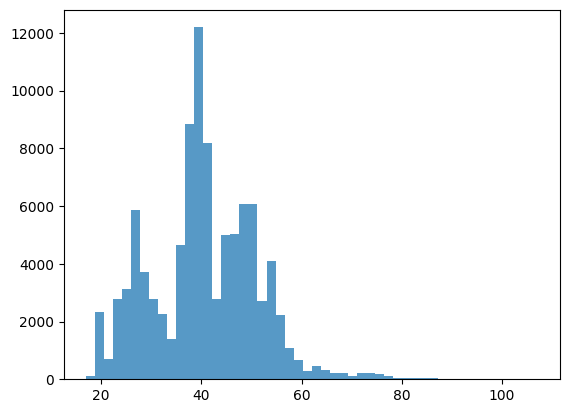

In [11]:
# plot the lengths as a distribution 
plt.hist(all_lengths, bins=50, alpha=0.75)

In [5]:
tokenizer.vocab_size

2048